In [19]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import division

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
sns.set(style="white", context="talk")

print "Done!"

Done!


In [23]:
def classify(grid, X_train, y_train, X_test, y_test):
    results = dict()
    
    #Training the model using grid search & cross validation
    start_time = time.time()
    grid.fit(X_train, y_train)
    end_time = time.time() - start_time
    results['training_time'] = end_time
    
    
    #Testing the model on the held out test data set
    start_time = time.time()
    grid_test = grid.predict(X_test)
    end_time = time.time() - start_time
    results['testing_time'] = end_time
    
    results['accuracy'] = metrics.accuracy_score(y_test, grid_test)
    results['report'] = metrics.classification_report(y_test, grid_test)
    results['matrix'] = metrics.confusion_matrix(y_test, grid_test)
    
    results['grid'] = grid
    
    return(results)

def get_feature_importances(grid, X_test):
    #Returns a dataframe with feature importance info
    ls = list()
    for a,b in enumerate(grid.best_estimator_.feature_importances_):
        ls.append({'feature':X_test.columns[a], 'importance':b})
    feature_importances = pd.DataFrame(ls).sort_values(by = ['importance'], ascending=False)
    return(feature_importances)

def plot_feature_importances(feature_importances):
    ax = sns.stripplot(x = "importance", y = "feature", data = feature_importances)
    ax.set(xlabel = 'Importance', ylabel='Feature')
    return(ax)

def plot_validation_curve(model, X, y, items):
    train_scores, test_scores = validation_curve(model,
                                                 X,
                                                 y,
                                                 param_name=items['param_name'],
                                                 param_range=items['param_range'],
                                                 cv=10, 
                                                 scoring=items['scoring'],
                                                 n_jobs=-1)
    
    train_score_means = np.mean(train_scores, axis=1)
    test_score_means = np.mean(test_scores, axis=1)

    plt.title(items['title'])
    plt.xlabel(items['param_name'])
    plt.ylabel(items['scoring'])
    plt.ylim(0.0, 1.0)
    plt.plot(items['param_range'], train_score_means, color="darkorange", label="Training Score")
    plt.plot(items['param_range'], test_score_means, color="navy", label="Testing Score")
    plt.legend(loc="best")
    
    return(plt)


def plot_learning_curve(model, X, y, items):
    train_sizes_abs, train_scores, test_scores = learning_curve(model,
                                                                X,
                                                                y,
                                                                train_sizes=items['train_sizes'],
                                                                cv=items['cv'],
                                                                n_jobs=-1)
    
    train_score_means = np.mean(train_scores, axis=1)
    test_score_means = np.mean(test_scores, axis=1)

    plt.title(items['title'])
    plt.xlabel('train_sizes')
    plt.ylabel(items['scoring'])
    plt.ylim(0.0, 1.0)
    plt.plot(train_sizes_abs, train_score_means, color="darkorange", label="Training Score")
    plt.plot(train_sizes_abs, test_score_means, color="navy", label="Testing Score")
    plt.legend(loc="best")
    
    return(plt)

In [5]:
#Reading in the data
df = pd.read_csv("/Users/nandu/desktop/WORK/kaggle/HR_comma_sep.csv").rename(columns={"sales":"department"})

#One hot encoding - Transforming all the categorical variables to numerical variables
salary = pd.get_dummies(df['salary'], drop_first=False)
department = pd.get_dummies(df['department'], drop_first=False)
df.drop(['salary', 'department'], axis=1, inplace=True)
df = pd.concat([df, salary, department], axis=1)

#Splitting the dataset into two parts, train set and test set, using stratified sampling
train, test = train_test_split(df, test_size = 0.3, random_state = 5, stratify = df['left'])
X_train = train.ix[:, df.columns.difference(['left'])]
y_train = train.ix[:, 'left']
X_test = test.ix[:, df.columns.difference(['left'])]
y_test = test.ix[:, ['left']]

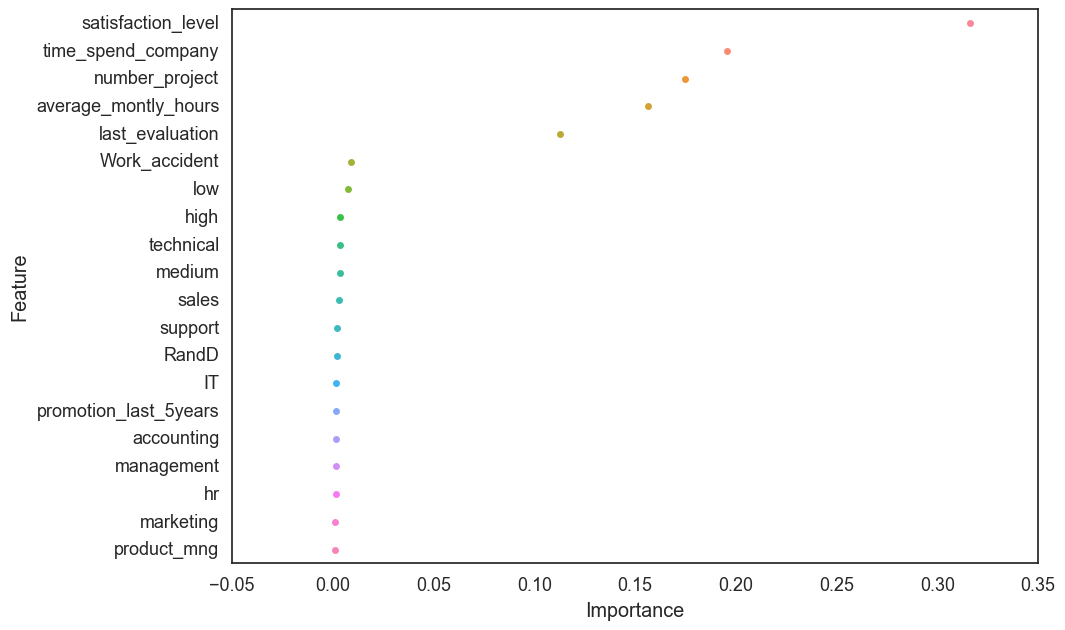

In [6]:
#Random Forests classification
n = range(1, 51)
param_grid = dict(n_estimators=n)

random_forests = RandomForestClassifier(random_state=5)
grid = GridSearchCV(random_forests, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

results = classify(grid, X_train, y_train, X_test, y_test)

#Visualizing the importance of the features
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
#It is also known as the Gini importance.

feature_importances = get_feature_importances(results['grid'], X_test)

ax = plot_feature_importances(feature_importances)
sns.plt.show()

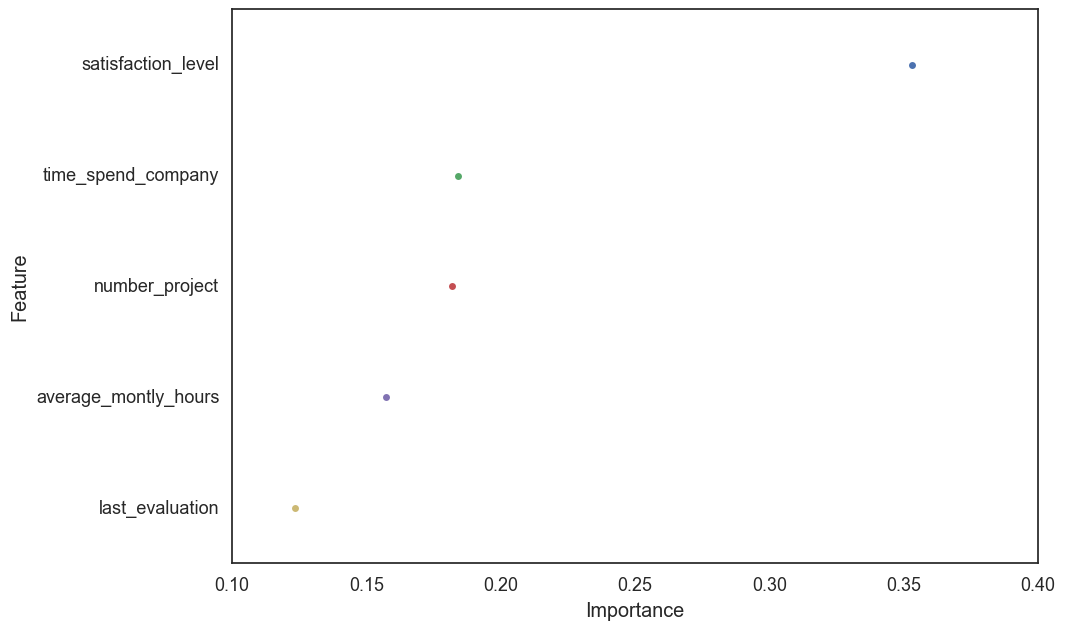

In [84]:
#Random Forests classification using only the top features
top_features = feature_importances[:5]['feature'].tolist() + ['left']
new_df = df[top_features]

train, test = train_test_split(new_df, test_size = 0.3, random_state = 5, stratify = new_df['left'])
X_train = train.ix[:, new_df.columns.difference(['left'])]
y_train = train.ix[:, 'left']
X_test = test.ix[:, new_df.columns.difference(['left'])]
y_test = test.ix[:, ['left']]

n = range(1, 51)
param_grid = dict(n_estimators=n)
random_forests = RandomForestClassifier(random_state=5)
grid = GridSearchCV(random_forests, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

results = classify(grid, X_train, y_train, X_test, y_test)
feature_importances = get_feature_importances(results['grid'], X_test)
ax = plot_feature_importances(feature_importances)
sns.plt.show()

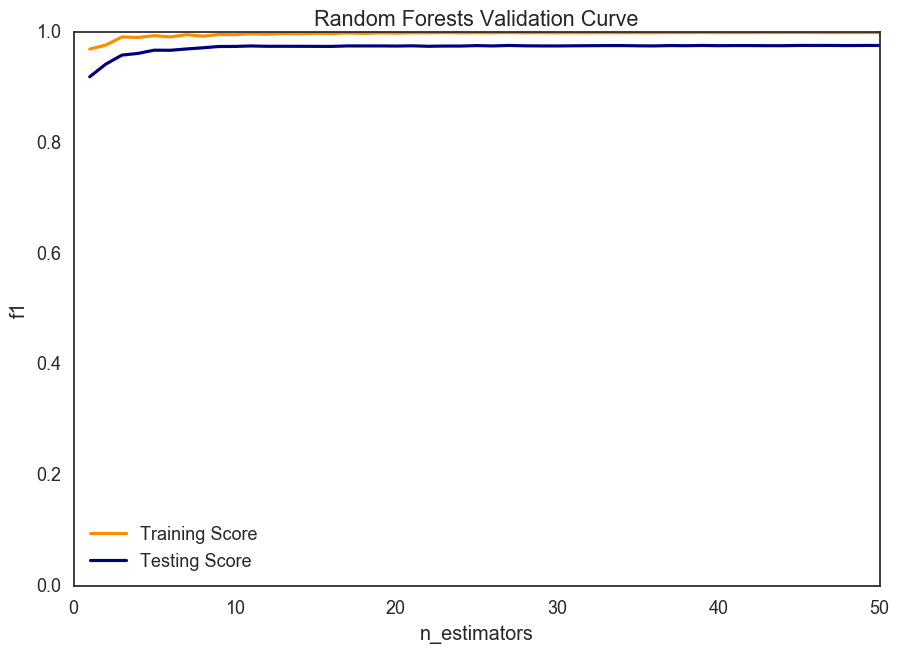

In [16]:
#Random Forests Validation Curve

random_forests_classifier = RandomForestClassifier(random_state=5)
n_estimators = range(1, 51)

items = {'title':'Random Forests Validation Curve',
         'param_range':n_estimators,
         'param_name':'n_estimators',
         'scoring':'f1'}

plt = plot_validation_curve(random_forests_classifier, X_train, y_train, items)
plt.show()

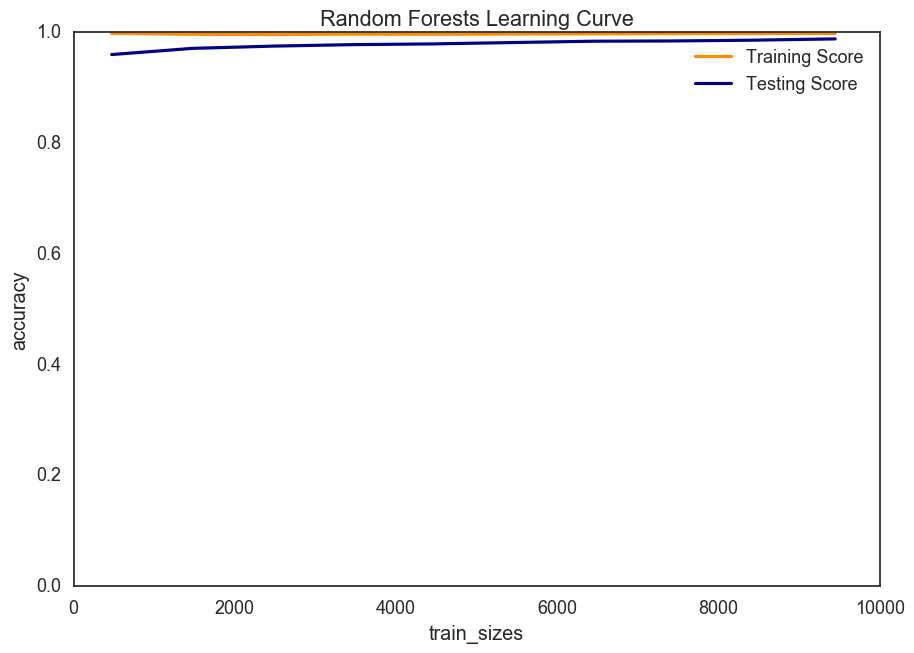

In [24]:
#Random Forests Learning Curve

random_forests_classifier = RandomForestClassifier(random_state=5, n_estimators=10)
train_sizes = np.linspace(.05, 1.0, 10)

items = {'title':'Random Forests Learning Curve',
         'train_sizes':train_sizes,
         'cv':10,
         'scoring':'accuracy'}

plt = plot_learning_curve(random_forests_classifier, X_train, y_train, items)
plt.show()

In [4]:
#SVM Classification
kernel = ['sigmoid', 'rbf']
param_grid = dict(kernel=kernel)

support_vector_classifier = svm.SVC(random_state=5)
grid = GridSearchCV(support_vector_classifier, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

results = classify(grid, X_train, y_train, X_test, y_test)

print "Done!"

Done!


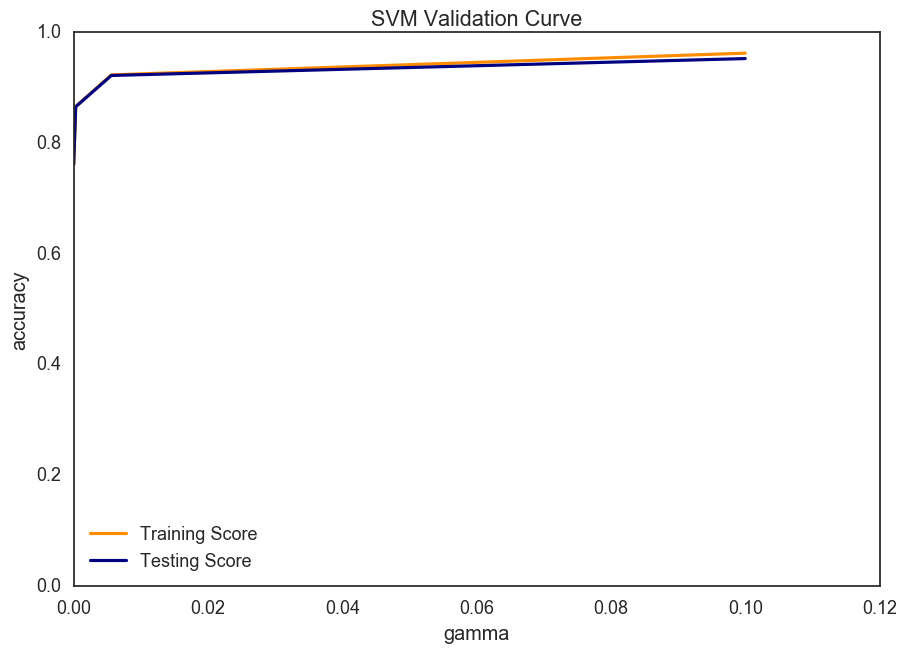

In [15]:
#SVM Validation Curve
support_vector_classifier = svm.SVC(random_state=5, kernel="rbf")
gamma = np.logspace(-6, -1, 5)

items = {'title':'SVM Validation Curve',
         'param_range':gamma,
         'param_name':'gamma',
         'scoring':'accuracy'}

plt = plot_validation_curve(support_vector_classifier, X_train, y_train, items)
plt.show()

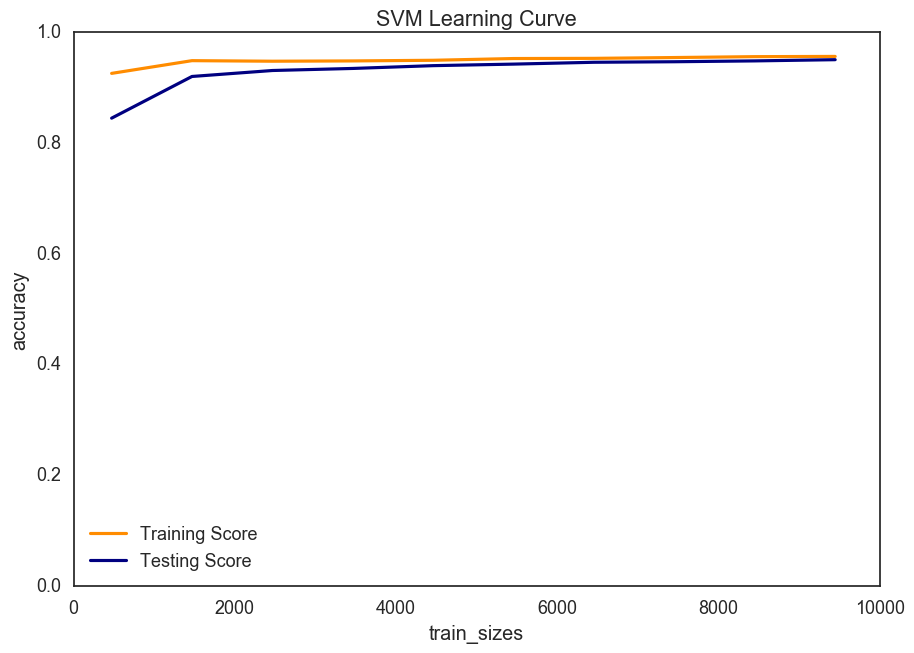

In [25]:
#SVM Learning Curve

support_vector_classifier = svm.SVC(random_state=5, kernel="rbf")
train_sizes = np.linspace(.05, 1.0, 10)

items = {'title':'SVM Learning Curve',
         'train_sizes':train_sizes,
         'cv':10,
         'scoring':'accuracy'}

plt = plot_learning_curve(support_vector_classifier, X_train, y_train, items)
plt.show()

In [207]:
#KNN Classification
p = range(1, 3)
n_neighbors = range(1, 101)
param_grid = dict(p=p, n_neighbors=n_neighbors)

knn_classifier = KNeighborsClassifier()
grid = GridSearchCV(knn_classifier, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

results = classify(grid, X_train, y_train, X_test, y_test)

print "Done!"

Done!


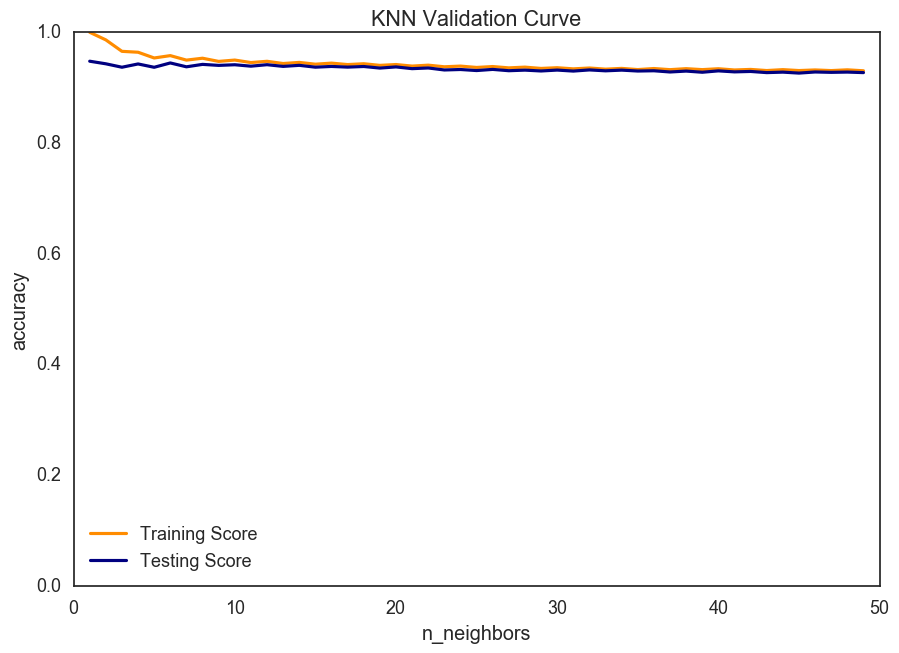

In [20]:
#KNN Validation curve

knn_classifier = KNeighborsClassifier()
n_neighbors = range(1, 50)

items = {'title':'KNN Validation Curve',
         'param_range':n_neighbors,
         'param_name':'n_neighbors',
         'scoring':'accuracy'}

plt = plot_validation_curve(knn_classifier, X_train, y_train, items)
plt.show()

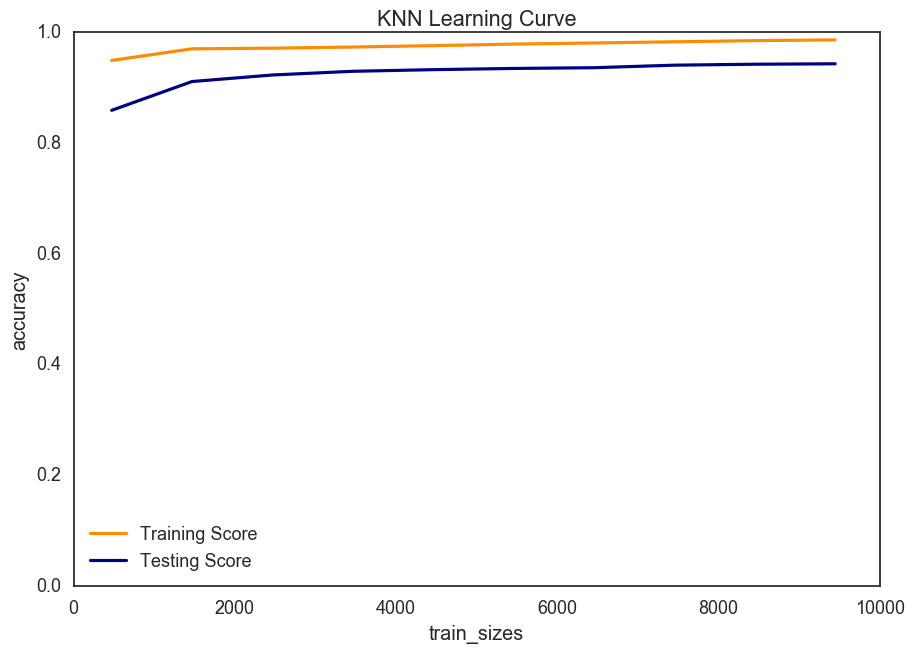

In [26]:
#KNN Learning curve

#train_sizes = [np.round(percent*X_train.shape[0]).astype(int) for percent in np.arange(0.1, 1.1, 0.1)]
#train_sizes = [percent for percent in np.arange(0.1, 1.1, 0.1)]

knn_classifier = KNeighborsClassifier(n_neighbors=2)
train_sizes = np.linspace(.05, 1.0, 10)

items = {'title':'KNN Learning Curve',
         'train_sizes':train_sizes,
         'cv':10,
         'scoring':'accuracy'}

plt = plot_learning_curve(knn_classifier, X_train, y_train, items)
plt.show()

In [ ]:
from sklearn.datasets import make_blobs


X, y = make_blobs(n_samples=300, centers=4, random_state=2, cluster_std=1.0)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap="rainbow")
plt.show()

In [106]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X,y)

In [113]:
def visualize_classifier(model, X, y, ax=None, cmap="rainbow"):
    ax = ax or plt.gca()
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
    
    ax.axis('tight')
    ax.axis('off')
    
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)
    
    ax.set(xlim=xlim, ylim=ylim)
    
    return ax

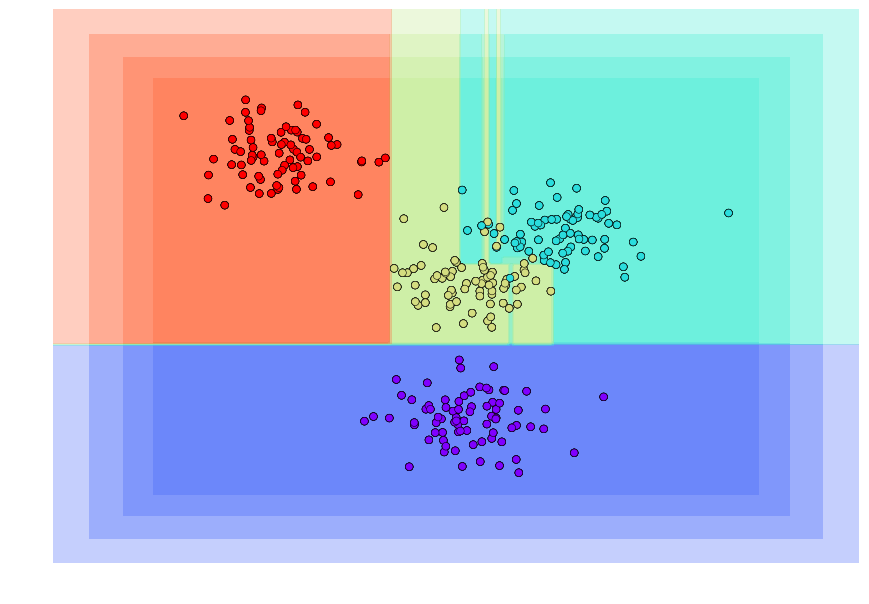

In [115]:
ax = visualize_classifier(DecisionTreeClassifier(), X, y)
plt.show()